In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import netCDF4
import pandas as pd

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [4]:
# open precipitation data
file_precip = '/scratch/myuan5/CLIM680/1precip.mon.total.v401.nc'
ds_precip = xr.open_dataset(file_precip)
ds_precip

precipitation = ds_precip['precip']
precipitation

<xarray.DataArray 'precip' (time: 1380, lat: 360, lon: 720)> Size: 1GB
[357696000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 1kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * time     (time) datetime64[ns] 11kB 1900-01-01 1900-02-01 ... 2014-12-01
Attributes:
    units:         cm
    var_desc:      Precipitation
    level_desc:    Surface
    statistic:     Total
    parent_stat:   Other
    long_name:     Monthly total of precipitation
    cell_methods:  time: sum
    avg_period:    0000-01-00 00:00:00
    actual_range:  [  0.   776.75]
    dataset:       Univ. of Delaware Precipitation and Air Temp v4.01
    valid_range:   [   0. 1200.]

In [3]:
min_value = precipitation.min().values
max_value = precipitation.max().values
print(max_value)
print(min_value)

776.75
0.0


In [6]:
# Create a list of month names for the subplots
month_names = [
    'January', 'February', 'March', 'April',
    'May', 'June', 'July', 'August',
    'September', 'October', 'November', 'December'
]

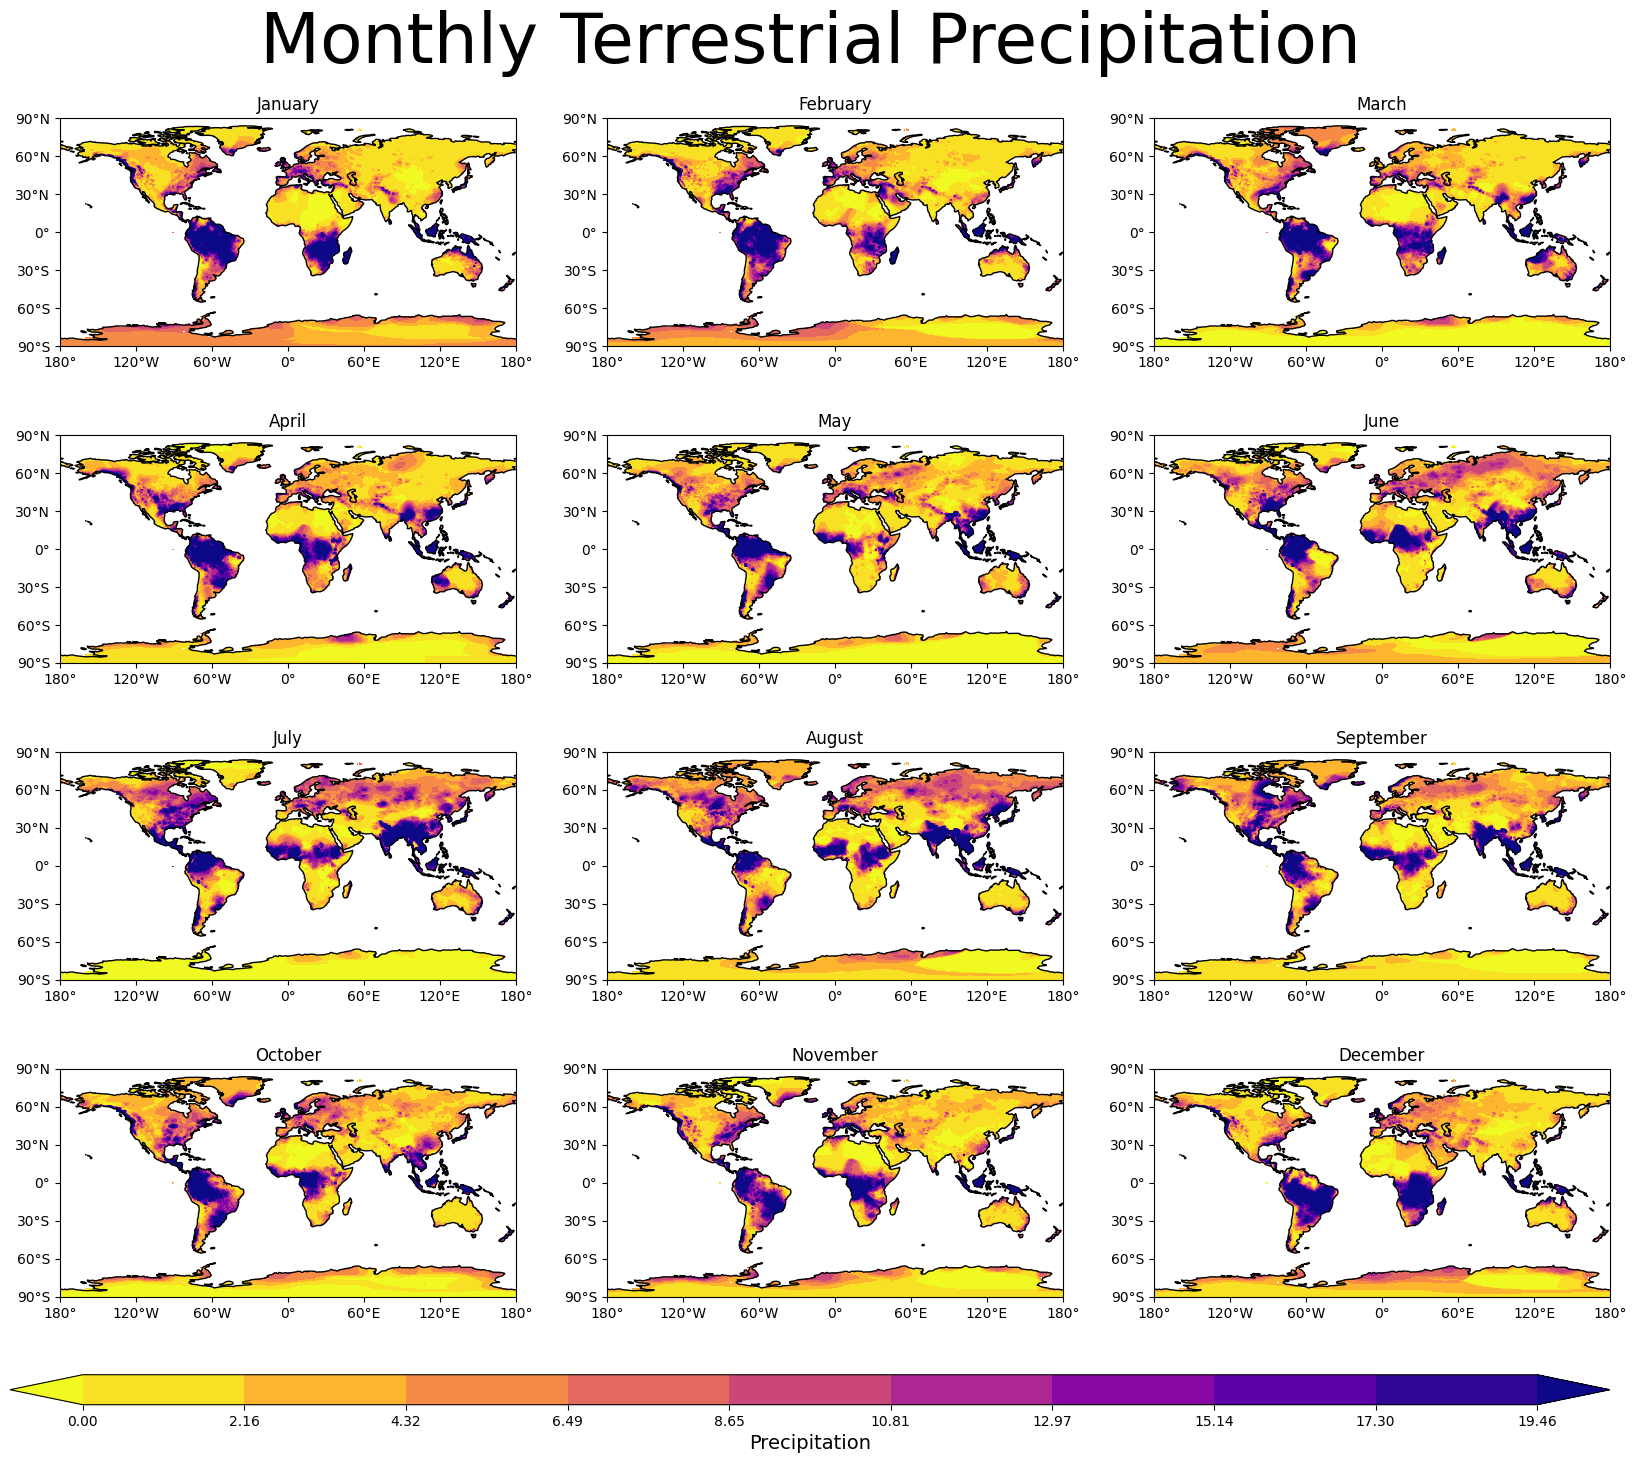

In [8]:
# Define the figure and each axis for the 4 rows and 3 columns
fig, axs = plt.subplots(4, 3, figsize=(20, 15), subplot_kw={'projection': ccrs.PlateCarree()})

# Flatten it into a 1-D array
axs = axs.flatten()

# Calculate the 5th and 95th percentiles of the precipitation data
min_value = np.nanpercentile(precipitation, 5)
max_value = np.nanpercentile(precipitation, 95)

# Define contour levels
levels = 10
clevs = np.linspace(min_value, max_value, levels)

# Define colormap
cmap = 'plasma_r'

# Loop over all of the months and plot
for i, month in enumerate(month_names):
    # Select the month
    month_data = precipitation.isel(time=i)
    
    # Add the cyclic point
    month_data, lons = add_cyclic_point(month_data, coord=ds_precip['lon'])
        
    # Contour plot
    cs = axs[i].contourf(lons, ds_precip['lat'], month_data, clevs,
                         transform=ccrs.PlateCarree(),
                         cmap=cmap, extend='both')
    
    # Longitude labels
    axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Latitude labels
    axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)

    # Title each subplot with the name of the month
    axs[i].set_title(month)
    
    #Draw the coastines for each subplot
    axs[i].coastlines()
    
# Draw the colorbar
cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', label='Precipitation (cm)')
cbar.ax.set_xlabel('Precipitation', fontsize=14, ha='center')

# Add title
plt.suptitle('Monthly Terrestrial Precipitation', fontsize=50, ha='center')

# Adjust the space between the title and the subplots
fig.subplots_adjust(top=0.92)

In [9]:
# choose ESPI-ENSO Precipitation Index as my index
file_enso = '/scratch/myuan5/CLIM680/espi.csv'
df_enso = pd.read_csv(file_enso)
df_enso

,Date,ESPI
0,1/1/79,1.015
1,2/1/79,0.705
2,3/1/79,0.173
3,4/1/79,-0.152
4,5/1/79,-0.096
...,...,...
535,8/1/23,1.009
536,9/1/23,0.801
537,10/1/23,1.312
538,11/1/23,-9999.000


In [10]:
df_enso['ESPI'] = df_enso['ESPI'].replace(-9999.000, np.nan)
df_enso['Date'] = pd.to_datetime(df_enso['Date'])
df_enso

/tmp/ipykernel_743397/528084877.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_enso['Date'] = pd.to_datetime(df_enso['Date'])


,Date,ESPI
0,1979-01-01,1.015
1,1979-02-01,0.705
2,1979-03-01,0.173
3,1979-04-01,-0.152
4,1979-05-01,-0.096
...,...,...
535,2023-08-01,1.009
536,2023-09-01,0.801
537,2023-10-01,1.312
538,2023-11-01,NaN


In [11]:
# define phases
elnino = df_enso['ESPI'].where(df_enso['ESPI'] >= 1)
lanina = df_enso['ESPI'].where(df_enso['ESPI'] <= -1)
neutral = df_enso['ESPI'].where((df_enso['ESPI'] > -1) & (df_enso['ESPI'] < 1))

In [12]:
# count values for each phase
elnino_count = elnino.count()
neutral_count = neutral.count()
lanina_count = lanina.count()

counts = [elnino_count, neutral_count, lanina_count]

In [13]:
# match data time ranges
start_date = df_enso['Date'].iloc[0]
end_date = df_enso['Date'].iloc[-1]

da_precip = ds_precip.precip.sel(time=slice(start_date, end_date))
da_precip

<xarray.DataArray 'precip' (time: 432, lat: 360, lon: 720)> Size: 448MB
array([[[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ...,
        [0.  , 0.  , ..., 0.  , 0.  ],
        [0.01, 0.01, ..., 0.01, 0.01]],

       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ...,
        [0.  , 0.  , ..., 0.  , 0.  ],
        [0.  , 0.  , ..., 0.  , 0.  ]],

       ...,

       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ...,
        [0.  , 0.  , ..., 0.  , 0.  ],
        [0.  , 0.  , ..., 0.  , 0.  ]],

       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ...,
        [0.  , 0.  , ..., 0.  , 0.  ],
        [0.02, 0.02, ..., 0.02, 0.02]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 1kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * time     (time) datetime64[ns] 3kB 1979-01-01 1979-02-01 ... 2014-12-01
Attributes:
    units:         cm
    var_desc:      Precipitation
    level_desc:    Surface
    statistic:     Total
    parent_stat:   Other
    long_name:     Monthly total of precipitation
    cell_methods:  time: sum
    avg_period:    0000-01-00 00:00:00
    actual_range:  [  0.   776.75]
    dataset:       Univ. of Delaware Precipitation and Air Temp v4.01
    valid_range:   [   0. 1200.]

In [14]:
#make anomalies of precipitation
da_climo = da_precip.groupby('time.month').mean()
da_anoms = da_precip.groupby('time.month')-da_climo
da_anoms

<xarray.DataArray 'precip' (time: 432, lat: 360, lon: 720)> Size: 448MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.00305556, -0.0025    , -0.0025    , ..., -0.00305556,
         -0.00305556, -0.00305556],
        [-0.0025    , -0.0025    , -0.0025    , ..., -0.0025    ,
         -0.0025    , -0.0025    ],
        [ 0.00611111,  0.00611111,  0.00611111, ...,  0.00611111,
          0.00611111,  0.00611111]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [-0.0025    , -0.0025    , -0.0025    , ..., -0.0025    ,
         -0.0025    , -0.0025    ],
        [-0.00138889, -0.00138889, -0.00138889, ..., -0.00138889,
         -0.00138889, -0.00138889],
        [-0.00055556, -0.00055556, -0.00055556, ..., -0.00083333,
         -0.00083333, -0.00055556]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.00333333, -0.00333333, -0.00333333, ..., -0.00333333,
         -0.00333333, -0.00333333],
        [-0.00694445, -0.00694445, -0.00694445, ..., -0.00694445,
         -0.00694445, -0.00694445],
        [-0.00111111, -0.00111111, -0.00111111, ..., -0.00111111,
         -0.00111111, -0.00111111]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 1kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * time     (time) datetime64[ns] 3kB 1979-01-01 1979-02-01 ... 2014-12-01
    month    (time) int64 3kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12

In [15]:
elnino_time = df_enso.loc[elnino.dropna().index, 'Date']
lanina_time = df_enso.loc[lanina.dropna().index, 'Date']
neutral_time = df_enso.loc[neutral.dropna().index, 'Date']

elnino_time = pd.to_datetime(elnino_time)
lanina_time = pd.to_datetime(lanina_time)
neutral_time = pd.to_datetime(neutral_time)

matching_elnino = elnino_time[elnino_time.isin(da_anoms['time'].values)]
matching_lanina = lanina_time[lanina_time.isin(da_anoms['time'].values)]
matching_neutral = neutral_time[neutral_time.isin(da_anoms['time'].values)]

In [16]:
elnino_precip = da_anoms.sel(time=matching_elnino.values).mean(dim='time')
lanina_precip = da_anoms.sel(time=matching_lanina.values).mean(dim='time')
neutral_precip = da_anoms.sel(time=matching_neutral.values).mean(dim='time')

comp_precip = [elnino_precip, lanina_precip, neutral_precip]
comp_precip

[<xarray.DataArray 'precip' (lat: 360, lon: 720)> Size: 1MB
 array([[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-0.00566308, -0.00561828, -0.00561828, ..., -0.0059095 ,
         -0.00586021, -0.00566308],
        [-0.0052509 , -0.0052509 , -0.0052733 , ..., -0.00527778,
         -0.0052509 , -0.0052509 ],
        [-0.00426523, -0.00427867, -0.00427867, ..., -0.00428315,
         -0.00428315, -0.00426523]], dtype=float32)
 Coordinates:
   * lat      (lat) float32 1kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
   * lon      (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8,
 <xarray.DataArray 'precip' (lat: 360, lon: 720)> Size: 1MB
 array([[           nan,            nan,            nan, ...,
 

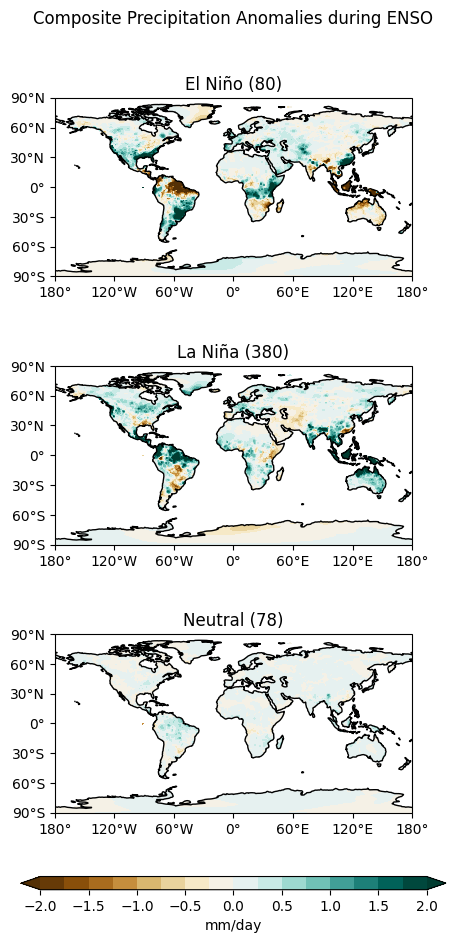

In [17]:
labels=['El Niño','La Niña', 'Neutral']
clevs = np.arange(-2.0,2.1,0.25)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=3,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,11))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array (just 3 rows)
axs = axs.flatten()

#Loop over all of the seasons and plot
for i,enso in enumerate(comp_precip):

        # Select the season
        data = comp_precip[i]

        # Add the cyclic point
        data,lons = add_cyclic_point(data,coord=comp_precip[i]['lon'])

        # Contour plot
        cs=axs[i].contourf(lons,comp_precip[i]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

       # Longitude labels
        axs[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)
        
        # Latitude labels
        axs[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i]+' ('+str(counts[i])+')')

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.012])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='mm/day')

# Add a big title at the top
plt.suptitle('Composite Precipitation Anomalies during ENSO') ;

In [18]:
# Calculate differences
diff_precip=[elnino_precip-neutral_precip, 
             lanina_precip-neutral_precip]

p = 0.05 # 95% confidence level, or 5% likelihood that the result arose by chance

from scipy.stats import ttest_ind

elnino_precip_vals = da_anoms.sel(time=matching_elnino.values)
lanina_precip_vals = da_anoms.sel(time=matching_lanina.values)
neutral_precip_vals = da_anoms.sel(time=matching_neutral.values)

In [19]:
tstat,pval = ttest_ind(elnino_precip_vals, 
                neutral_precip_vals, 
                equal_var = False)

tstat_neg,pval_neg = ttest_ind(lanina_precip_vals, 
                neutral_precip_vals, 
                equal_var = False)

In [20]:
mask_diff = diff_precip[0].where(pval <= p)
mask_diff_neg = diff_precip[1].where(pval_neg <= p)

Text(0.5, 0.98, 'Composite Precipitation Differences Negative-Neutral')

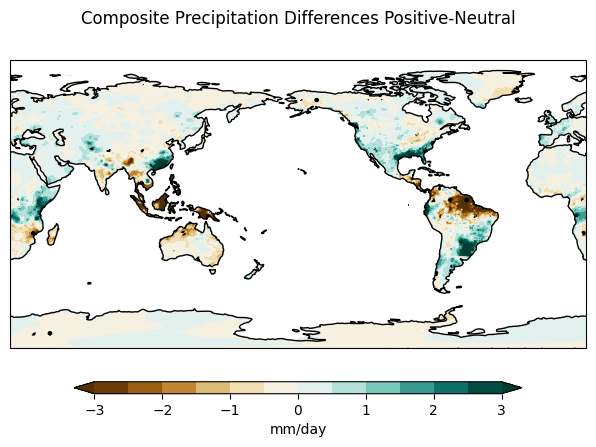

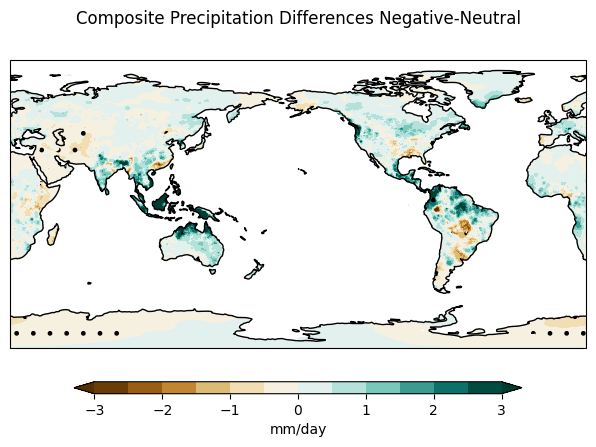

In [21]:
labels=['El Niño vs. Neutral']
clevs=np.arange(-3,3.5,0.5)
hatch_levs=[0]

# Define the figure and each axis for the 2 rows and 1 columns
fig, axs = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200.0)})


data=diff_precip[0]

# Add the cyclic point
data,lons=add_cyclic_point(data,coord=diff_precip[0]['lon'])
mask_data,lons=add_cyclic_point(mask_diff,coord=diff_precip[0]['lon'])

# Contour plot
cs=axs.contourf(lons,diff_precip[0]['lat'],data,clevs,
                transform = ccrs.PlateCarree(),
                cmap='BrBG',extend='both')

# Overlay of stippling
ss=axs.contourf(lons,diff_precip[0]['lat'],mask_data,[0,1],
                transform = ccrs.PlateCarree(),colors=['None'],
                hatches=['.',''],extend='both',alpha=0.0)
#change to hatches=['///',''] to get parallel lines

# Draw the coastines for each subplot
axs.coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.15, 0.18, 0.7, 0.025])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='mm/day')

# Add a big title at the top
plt.suptitle('Composite Precipitation Differences Positive-Neutral')


labels=['La Niña vs. Neutral']
clevs=np.arange(-3,3.5,0.5)
hatch_levs=[0]

# Define the figure and each axis for the 2 rows and 1 columns
fig, axs = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200.0)})


data=diff_precip[1]

# Add the cyclic point
data,lons=add_cyclic_point(data,coord=diff_precip[1]['lon'])
mask_data,lons=add_cyclic_point(mask_diff_neg,coord=diff_precip[1]['lon'])

# Contour plot
cs=axs.contourf(lons,diff_precip[1]['lat'],data,clevs,
                transform = ccrs.PlateCarree(),
                cmap='BrBG',extend='both')

# Overlay of stippling
ss=axs.contourf(lons,diff_precip[1]['lat'],mask_data,[0,1],
                transform = ccrs.PlateCarree(),colors=['None'],
                hatches=['.',''],extend='both',alpha=0.0)
#change to hatches=['///',''] to get parallel lines

# Draw the coastines for each subplot
axs.coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.15, 0.18, 0.7, 0.025])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='mm/day')

# Add a big title at the top
plt.suptitle('Composite Precipitation Differences Negative-Neutral')

In [22]:
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def label_latlon(ax,lons,lats):
    """ Add tick labels """
    # Define the xticks for longtitude
    ax.set_xticks(lons,crs=ccrs.PlateCarree())
    lon_formatter=cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)

    # Define ytick for latitude
    ax.set_yticks(lats,crs=ccrs.PlateCarree())
    lat_formatter=cticker.LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)

    return

In [23]:
pt=da_anoms.sel(lat=0,lon=360-180,method='nearest')
pt

<xarray.DataArray 'precip' (time: 432)> Size: 2kB
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan], dtype=float32)
Coordinates:
    lat      float32 4B 0.25
    lon      float32 4B 180.2
  * time     (time) datetime64[ns] 3kB 1979-01-01 1979-02-01 ... 2014-12-01
    month    (time) int64 3kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12

In [24]:
espi_da = xr.DataArray(df_enso['ESPI'].values, 
                       dims=['time'], 
                       coords={'time': pd.to_datetime(df_enso['Date']).values})

r_map = xr.corr(espi_da, da_anoms, dim='time')
r_map

<xarray.DataArray (lat: 360, lon: 720)> Size: 2MB
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [-0.0054059 , -0.00550352, -0.00550352, ..., -0.00584077,
        -0.00610871, -0.00521343],
       [-0.02440698, -0.02440698, -0.02488368, ..., -0.02440489,
        -0.02440698, -0.02440698],
       [-0.0366946 , -0.03670442, -0.03670442, ..., -0.03720364,
        -0.03720364, -0.0366946 ]])
Coordinates:
  * lat      (lat) float32 1kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8

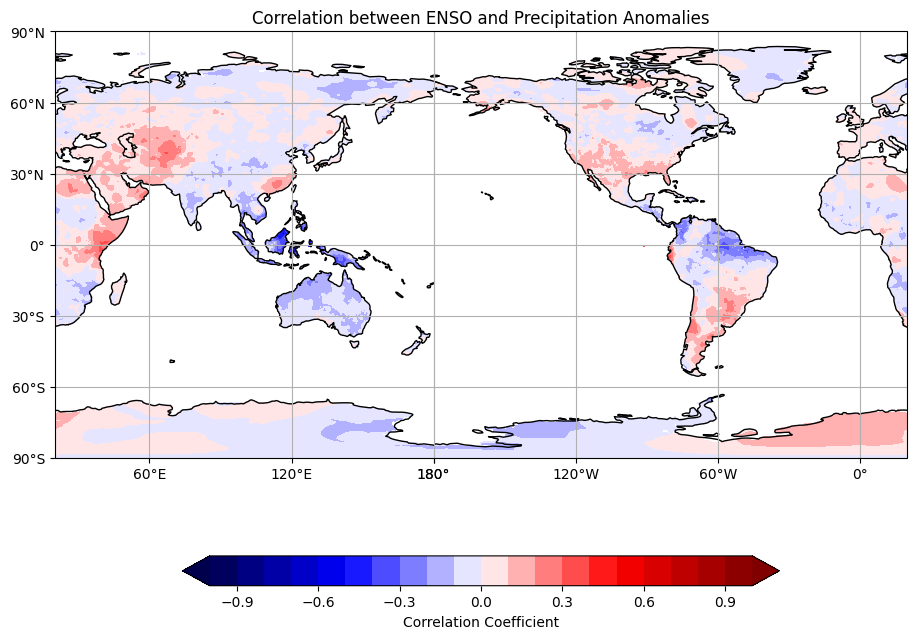

In [26]:
clevs=np.arange(-1,1.1,0.1)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree(central_longitude=200))

# Add cyclic point
data=r_map
data,lon=add_cyclic_point(r_map,coord=da_anoms['lon'])

# Make a filled contour plot
cs=ax.contourf(lon,da_anoms['lat'],
            data,clevs,
            transform=ccrs.PlateCarree(),
            cmap='seismic',extend='both')

# Add coastlines
ax.coastlines()

# Add gridlines
ax.gridlines()

label_latlon(ax,np.arange(-180,181,60),np.arange(-90,91,30))
# Define the xticks for longtitude 
#ax.set_xticks(np.arange(-180,181,60),crs=ccrs.PlateCarree())
#lon_formatter=cticker.LongitudeFormatter()
#ax.xaxis.set_major_formatter(lon_formatter)

# Define ytick for latitude
#ax.set_yticks(np.arange(-90,91,30),crs=ccrs.PlateCarree())
#lat_formatter=cticker.LatitudeFormatter()
#ax.yaxis.set_major_formatter(lat_formatter)

# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Correlation Coefficient')

# Add title
plt.title('Correlation between ENSO and Precipitation Anomalies') ;

In [27]:
from scipy.stats import pearsonr

In [29]:
nx=len(da_anoms['lon'])
ny=len(da_anoms['lat'])

p_array=np.zeros((ny,nx))
r_array=np.zeros((ny,nx))

t_start = time.perf_counter()
for i in range(nx):
    for j in range(ny):
        r,p = pearsonr(df_enso['ESPI'],da_anoms[:,j,i])
        r_array[j,i] = r
        p_array[j,i] = p
#r_array.shape
print(f"{time.perf_counter()-t_start:0.2f} s")

ValueError: `x` and `y` must have the same length along `axis`.

In [32]:
# Truncate df_enso to match the length of da_anoms['time']
df_enso_aligned = df_enso.sel(time=da_anoms['time'].values[:len(da_anoms['time'])])

# Now you can calculate the Pearson correlation
r_array = np.zeros((ny, nx))
p_array = np.zeros((ny, nx))

t_start = time.perf_counter()
for i in range(nx):
    for j in range(ny):
        # Now that both time series are aligned, compute the correlation
        r, p = pearsonr(df_enso_aligned['ESPI'], da_anoms[:, j, i].values)
        r_array[j, i] = r
        p_array[j, i] = p

print(f"{time.perf_counter() - t_start:0.2f} s")

AttributeError: 'DataFrame' object has no attribute 'sel'